# Scenario Generator

The purpose of this notebook is to generate scenarios in a given domain.
For now, it assumes:
- There are two land uses, "urban" and "forest"
- "Urban" land use is contiguous (one patch), and fits entirely within the domain
- "Urban land use total area is 30 cells
- The total domain dimensions are 10 (dy) x 12 (dx) cells (`mat = np.ones((12,10))`)

Requires the following to install modules:

```
f2py -c -m subsurface createpfb3.f createpfb2.f writepfb.f
f2py -c -m clm createclmvegm.f

```

In [1]:
import numpy as np
import itertools
from pylab import *
from subsurface import createpfb3, createpfb2
from clm import createclmvegm
import numpy as np
import subprocess

%matplotlib inline

In [2]:
def find_factors(value):
    '''
    A function to get all factor pairs of a given integer
    Outputs a list of tuples
    '''
    factors = []
    for i in range(1, int(value**0.5)+1):
        if value % i == 0:
            factors.append((float(i), value / i))
    return factors

def prune_f_pairs(f_pairs, dom_dx, dom_dy):
    '''
    Removes factor pairs whose dimensions exceed the domains
    (will not fit into domain as one "patch")
    '''
    new_fp = []
    for f in f_pairs:
        if max(f) > max(dom_dx,dom_dy): # one pair of the factor exceeds the domain, need to check if it exceeds the other
            if max(f) <= min(dom_dx,dom_dy): # if it does, then don't keep this pair
                new_fp.append(f)
        else:
            new_fp.append(f)
        
    return(new_fp)

def make_combinations(list1, list2):
    '''
    make combinations given two lists
    '''
    combs = []
    for element in itertools.product(list1, list2):
            combs.append(element)
    return(combs)
    
def get_upper_left_index(dom_x, dom_y, f_pairs):
    '''
    A list of feasible upper left indexes, given dims of domain
    and dims of patch
    '''

    results = []
    
    for f in f_pairs:
    
        # can patch's longside be oriented on x?
        if max(f) <= dom_x:
            patch_dims = (max(f), min(f))
            x_ind_list = list(range(0, dom_x - int(max(f)) + 1) )
            # then the short side (min(f)), has to be oriented on y:
            y_ind_list = list(range(0, dom_y - int(min(f)) + 1) )

            upper_left_indices = make_combinations(x_ind_list, y_ind_list)
            
            results.append({'patch_xdim': patch_dims[0],
                        'patch_ydim':  patch_dims[1],
                        'upperleftind':upper_left_indices })
        else:
            print("cannot be oriented with long side on x")
            upper_left_indices = []

        # can patch's longside be oriented on y?
        if max(f) <= dom_y:
            patch_dims = (min(f), max(f))
            x_ind_list = list(range(0, dom_x - int(min(f)) + 1) )
            y_ind_list = list(range(0, dom_y - int(max(f)) + 1) )  

            upper_left_indices = make_combinations(x_ind_list, y_ind_list)
            
            results.append({'patch_xdim': patch_dims[0],
                        'patch_ydim':  patch_dims[1],
                        'upperleftind':upper_left_indices })
        else:
            print("cannot be oriented with long side on y")
            upper_left_indices = []

    return(results)


In [3]:
fp = find_factors(30)
fp = prune_f_pairs(fp,12,10)
#fp = prune_f_pairs(fp, dx, dy)
print(fp)
res_dict = get_upper_left_index(12,10,fp)

[(3.0, 10.0), (5.0, 6.0)]


In [4]:
res_dict

[{'patch_xdim': 10.0,
  'patch_ydim': 3.0,
  'upperleftind': [(0, 0),
   (0, 1),
   (0, 2),
   (0, 3),
   (0, 4),
   (0, 5),
   (0, 6),
   (0, 7),
   (1, 0),
   (1, 1),
   (1, 2),
   (1, 3),
   (1, 4),
   (1, 5),
   (1, 6),
   (1, 7),
   (2, 0),
   (2, 1),
   (2, 2),
   (2, 3),
   (2, 4),
   (2, 5),
   (2, 6),
   (2, 7)]},
 {'patch_xdim': 3.0,
  'patch_ydim': 10.0,
  'upperleftind': [(0, 0),
   (1, 0),
   (2, 0),
   (3, 0),
   (4, 0),
   (5, 0),
   (6, 0),
   (7, 0),
   (8, 0),
   (9, 0)]},
 {'patch_xdim': 6.0,
  'patch_ydim': 5.0,
  'upperleftind': [(0, 0),
   (0, 1),
   (0, 2),
   (0, 3),
   (0, 4),
   (0, 5),
   (1, 0),
   (1, 1),
   (1, 2),
   (1, 3),
   (1, 4),
   (1, 5),
   (2, 0),
   (2, 1),
   (2, 2),
   (2, 3),
   (2, 4),
   (2, 5),
   (3, 0),
   (3, 1),
   (3, 2),
   (3, 3),
   (3, 4),
   (3, 5),
   (4, 0),
   (4, 1),
   (4, 2),
   (4, 3),
   (4, 4),
   (4, 5),
   (5, 0),
   (5, 1),
   (5, 2),
   (5, 3),
   (5, 4),
   (5, 5),
   (6, 0),
   (6, 1),
   (6, 2),
   (6, 3),
   (6,

# For Loop to generate all for multiple numbers of urbanized

In [5]:
n_urb_list = [0, 10, 20, 30, 40, 50, 60, 70]
scens = {}

for n_urb in n_urb_list:
    scens['n_urb%03d' %n_urb] = {}
    # add base case manually:
    if n_urb == 0:
        i = 0
        scens['n_urb%03d' %n_urb]['%03d%03d' %(n_urb, i)] = np.ones((12,10) )
                    
    
    # find factors and create patch_dict
    print(n_urb)
    fp = find_factors(n_urb)
    fp = prune_f_pairs(fp,12,10)
    
    patch_dict = get_upper_left_index(12,10,fp)
    
    i = 0
    for patch in patch_dict:
        print('xdim: %s, ydim: %s' %(patch['patch_xdim'], patch['patch_ydim'])) 

        cur_patch_xdim = patch['patch_xdim']
        cur_patch_ydim = patch['patch_ydim']

        for unique_corner in patch['upperleftind']:
            mat = np.ones((12,10))  # Start with all "forest"

            x_start = int(unique_corner[0])
            x_end = int(x_start + cur_patch_xdim )
            y_start = int(unique_corner[1])
            y_end = int(y_start + cur_patch_ydim )

            mat[x_start : x_end , y_start:y_end] = 2      # Replace some with "urban"

            scens['n_urb%03d' %n_urb]['%03d%03d' %(n_urb, i)] = mat
            i +=1 
    

0
10
xdim: 10.0, ydim: 1.0
xdim: 1.0, ydim: 10.0
xdim: 5.0, ydim: 2.0
xdim: 2.0, ydim: 5.0
20
xdim: 10.0, ydim: 2.0
xdim: 2.0, ydim: 10.0
xdim: 5.0, ydim: 4.0
xdim: 4.0, ydim: 5.0
30
xdim: 10.0, ydim: 3.0
xdim: 3.0, ydim: 10.0
xdim: 6.0, ydim: 5.0
xdim: 5.0, ydim: 6.0
40
xdim: 10.0, ydim: 4.0
xdim: 4.0, ydim: 10.0
xdim: 8.0, ydim: 5.0
xdim: 5.0, ydim: 8.0
50
xdim: 10.0, ydim: 5.0
xdim: 5.0, ydim: 10.0
60
cannot be oriented with long side on y
xdim: 12.0, ydim: 5.0
xdim: 10.0, ydim: 6.0
xdim: 6.0, ydim: 10.0
70
xdim: 10.0, ydim: 7.0
xdim: 7.0, ydim: 10.0


In [6]:
scens

{'n_urb000': {'000000': array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])},
 'n_urb010': {'010000': array([[2., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [2., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [2., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [2., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [2., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [2., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [2., 1., 1., 1., 1., 1., 1

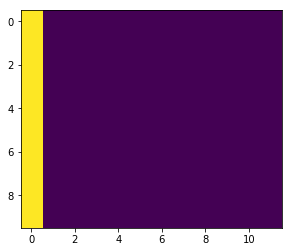

In [21]:
imshow(np.flip(np.rot90(np.flip(scens['n_urb010']['010030'], axis = 0)), axis = 1))

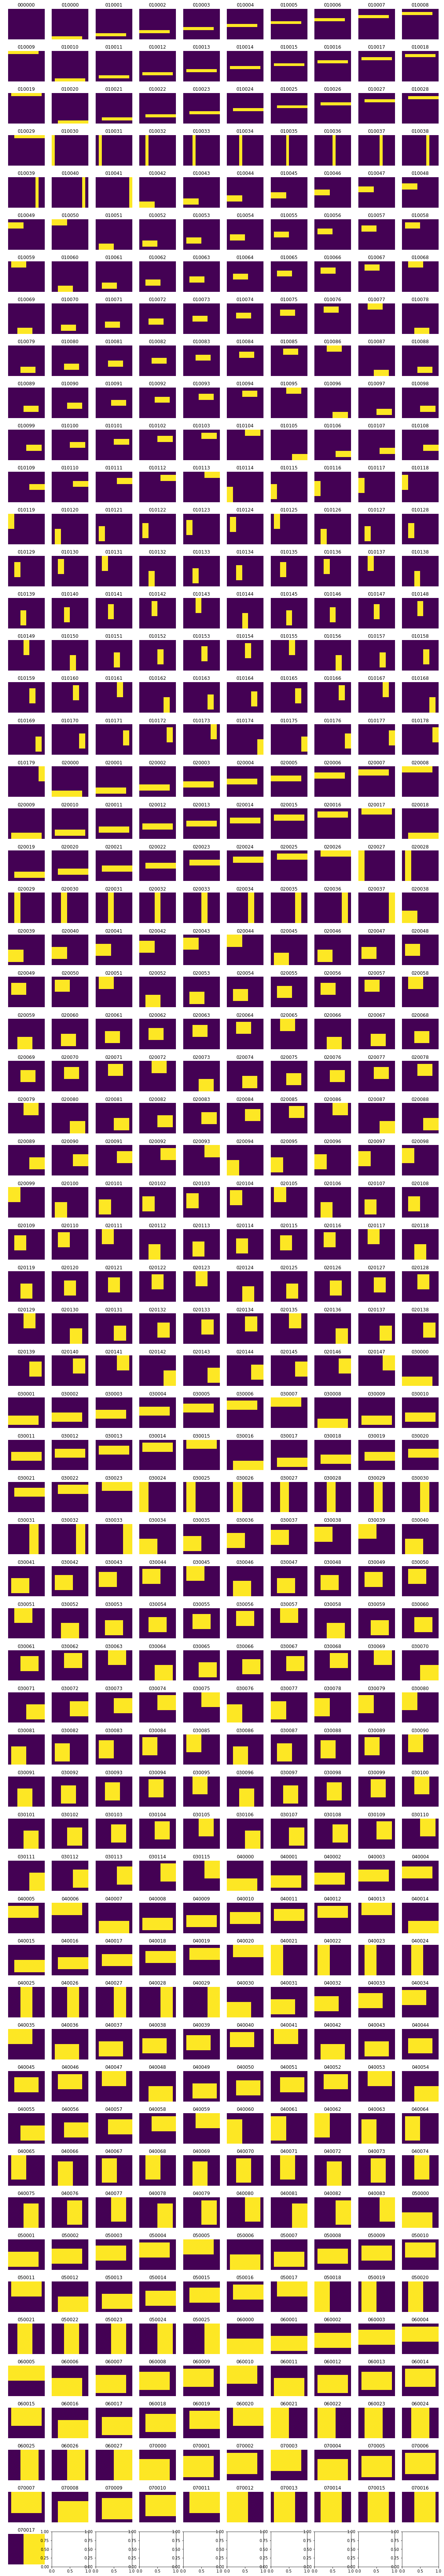

In [23]:
# Plotting

nrows = 61
ncols = 10

f, axarr = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))

axs = axarr.ravel()

i = 0

for n_urb in list(scens.keys()):
    for scen in list(scens[n_urb]):
        mat = scens[n_urb][scen]
        axs[i].imshow(np.flip(np.rot90(np.flip(mat, axis = 0)), axis = 1), interpolation = 'nearest')
        axs[i].set_title("%s" %scen)
        axs[i].axis('off')
        i += 1

In [24]:
f.savefig('scenario_key_601.png')

# For each scenario, create a directory, and subsurface input files

In [6]:
# first row is bottom of domain
# landco = 1 is "forest"
# landco = 2 is urban

landco_perm = np.array([[0.0002,0.0002],  # "bedrock" layer
                        [4.75,0.41],         # "saprolite"
                        [4.75,0.41],  
                        [4.75,0.41],  
                        [4.75,0.41],  
                        [4.75,0.41],   
                        [4.75,0.0000306],      # topsoil
                        [4.75,0.0000306],
                        [4.75,0.0000306],
                       [4.75,0.0000306]])        

landco_mann = np.array([[0.2,0.00001]])

landco_indic = np.array([[1.0,1.0], # bottom layer
                       [2.0,2.0],   #saprolite
                         [2.0,2.0],
                         [2.0,2.0],
                         [2.0,2.0],
                         [2.0,2.0],
                         [3.0,4.0],  #top layer 
                         [3.0,4.0],
                         [3.0,4.0],
                       [3.0,4.0]]) #top layer 


# This matrix maps permeabilities of the subsurface in each
# land cover type, in each subsurface layer
# Column 1 corresponds to LC type 1
# Column 2 corresponds to LC type 2

# p.19 in PF Manual: CLM vegetation classes.
# 4 is deciduous broadleaf
# 13 is urban and built up

landco_vegcl = np.array([[4,13]])

In [7]:
n_urb = list(scens.keys())[0]
n_urb
scen = list(scens[n_urb].keys())[0]
scens[n_urb][scen]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [8]:
n_urb

'n_urb000'

In [10]:
for n_urb in list(scens.keys()):
    #print(n_urb)
    # Create new directories, based on n_urb
    bashCommand = "mkdir /home/tclim/Dropbox/projects/pf_simple/new_scens/%s" %n_urb
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    process.wait()
    
    for scen in list(scens[n_urb].keys()):
        #print(scen)
        bashCommand = "mkdir /home/tclim/Dropbox/projects/pf_simple/new_scens/%s/%s" %(n_urb, scen)
        process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
        process.wait()
        
        #directory
        fdir = '/home/tclim/Dropbox/projects/pf_simple/new_scens/%s/%s' %(n_urb, scen)
        #print(fdir)
        
        # Create the permeability pfb
        a = createpfb3(arrin = scens[n_urb][scen], dx = 100, dy = 100, dz = 1, nlc = 2, nx = 12, ny = 10, nz = 10,
                       lcin = landco_perm, 
                       arroutfnam='%s/perm_scen.pfb' %fdir)

        # Create the mannings pfb
        b = createpfb2(arrin = scens[n_urb][scen], dx = 100, dy = 100, dz = 1, nlc = 2, nx = 12, ny = 10,
                       lcin_flat = landco_mann, 
                       arroutfnam='%s/mann_scen.pfb' %fdir)

        # Create the indicator pfb (for use for porosity)
        c = createpfb3(arrin = scens[n_urb][scen], dx = 100, dy = 100, dz = 1, nlc = 2, nx = 12, ny = 10, nz = 10,
                       lcin = landco_indic, 
                       arroutfnam='%s/ind_scen.pfb' %fdir)
        
        # CLM input
        createclmvegm(dx=100,dy=100,
                  arroutfnam='%s/drv_vegm.dat' %fdir,
                  arrin=scens[n_urb][scen],
             lcin_flat = landco_vegcl, lat = 39.313, lon = -76.688)


# Generate names of scenarios for autorun_script

In [26]:
n_urb_list = [0, 10, 20, 30, 40, 50, 60, 70]
scens = {}

for n_urb in n_urb_list:
    scens['n_urb%03d' %n_urb] = []
    
    if n_urb == 0:
        i = 0
        scens['n_urb%03d' %n_urb].append('%03d%03d' %(n_urb, i))

        
    fp = find_factors(n_urb)
    fp = prune_f_pairs(fp,12,10)
    
    patch_dict = get_upper_left_index(12,10,fp)
    
    i = 0
    for patch in patch_dict:
        cur_patch_xdim = patch['patch_xdim']
        cur_patch_ydim = patch['patch_ydim']

        for unique_corner in patch['upperleftind']:
            
            scens['n_urb%03d' %n_urb].append('%03d%03d' %(n_urb, i))
            i +=1 

cannot be oriented with long side on y


In [27]:
scens['n_urb000']

['000000']

In [28]:
scens['n_urb010']

['010000',
 '010001',
 '010002',
 '010003',
 '010004',
 '010005',
 '010006',
 '010007',
 '010008',
 '010009',
 '010010',
 '010011',
 '010012',
 '010013',
 '010014',
 '010015',
 '010016',
 '010017',
 '010018',
 '010019',
 '010020',
 '010021',
 '010022',
 '010023',
 '010024',
 '010025',
 '010026',
 '010027',
 '010028',
 '010029',
 '010030',
 '010031',
 '010032',
 '010033',
 '010034',
 '010035',
 '010036',
 '010037',
 '010038',
 '010039',
 '010040',
 '010041',
 '010042',
 '010043',
 '010044',
 '010045',
 '010046',
 '010047',
 '010048',
 '010049',
 '010050',
 '010051',
 '010052',
 '010053',
 '010054',
 '010055',
 '010056',
 '010057',
 '010058',
 '010059',
 '010060',
 '010061',
 '010062',
 '010063',
 '010064',
 '010065',
 '010066',
 '010067',
 '010068',
 '010069',
 '010070',
 '010071',
 '010072',
 '010073',
 '010074',
 '010075',
 '010076',
 '010077',
 '010078',
 '010079',
 '010080',
 '010081',
 '010082',
 '010083',
 '010084',
 '010085',
 '010086',
 '010087',
 '010088',
 '010089',
 '010090',

In [25]:
# test

for urb_scen in list(scens.keys()):
    print (urb_scen)
    
    for scen in list(scens[urb_scen]):
        print(scen)

n_urb000
000000
n_urb010
010000
010001
010002
010003
010004
010005
010006
010007
010008
010009
010010
010011
010012
010013
010014
010015
010016
010017
010018
010019
010020
010021
010022
010023
010024
010025
010026
010027
010028
010029
010030
010031
010032
010033
010034
010035
010036
010037
010038
010039
010040
010041
010042
010043
010044
010045
010046
010047
010048
010049
010050
010051
010052
010053
010054
010055
010056
010057
010058
010059
010060
010061
010062
010063
010064
010065
010066
010067
010068
010069
010070
010071
010072
010073
010074
010075
010076
010077
010078
010079
010080
010081
010082
010083
010084
010085
010086
010087
010088
010089
010090
010091
010092
010093
010094
010095
010096
010097
010098
010099
010100
010101
010102
010103
010104
010105
010106
010107
010108
010109
010110
010111
010112
010113
010114
010115
010116
010117
010118
010119
010120
010121
010122
010123
010124
010125
010126
010127
010128
010129
010130
010131
010132
010133
010134
010135
010136
010137
010138
01